## Crypto Prediction with LSTM: Litecoin (LTC)

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-09-26 15:55:52.391860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-26T00:00:00.0000000Z', 'time_period_end': '2023-09-27T00:00:00.0000000Z', 'time_open': '2023-09-26T00:06:03.0730000Z', 'time_close': '2023-09-26T19:46:41.8440000Z', 'price_open': 64.35, 'price_high': 65, 'price_low': 63.78, 'price_close': 63.87, 'volume_traded': 5204.44979246, 'trades_count': 1191}, {'time_period_start': '2023-09-25T00:00:00.0000000Z', 'time_period_end': '2023-09-26T00:00:00.0000000Z', 'time_open': '2023-09-25T00:00:54.0930000Z', 'time_close': '2023-09-25T23:45:37.3430000Z', 'price_open': 63.6, 'price_high': 65.01, 'price_low': 62.55, 'price_close': 64.27, 'volume_traded': 2253.97466743, 'trades_count': 922}, {'time_period_start': '2023-09-24T00:00:00.0000000Z', 'time_period_end': '2023-09-25T00:00:00.0000000Z', 'time_open': '2023-09-24T00:01:13.9070000Z', 'time_close': '2023-09-24T23:58:36.5100000Z', 'price_open': 65.08, 'price_high': 65.08, 'price_low': 63.29, 'price_close': 63.59, 'volume_traded': 1478.59795658, 'trades_count': 498}, 

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-26T00:00:00.0000000Z,2023-09-27T00:00:00.0000000Z,2023-09-26T00:06:03.0730000Z,2023-09-26T19:46:41.8440000Z,64.35,65.00,63.78,63.87,5204.449792,1191
1,2023-09-25T00:00:00.0000000Z,2023-09-26T00:00:00.0000000Z,2023-09-25T00:00:54.0930000Z,2023-09-25T23:45:37.3430000Z,63.60,65.01,62.55,64.27,2253.974667,922
2,2023-09-24T00:00:00.0000000Z,2023-09-25T00:00:00.0000000Z,2023-09-24T00:01:13.9070000Z,2023-09-24T23:58:36.5100000Z,65.08,65.08,63.29,63.59,1478.597957,498
3,2023-09-23T00:00:00.0000000Z,2023-09-24T00:00:00.0000000Z,2023-09-23T00:11:37.3310000Z,2023-09-23T23:51:18.5610000Z,64.62,65.27,64.47,65.09,3282.884739,688
4,2023-09-22T00:00:00.0000000Z,2023-09-23T00:00:00.0000000Z,2023-09-22T00:00:06.3170000Z,2023-09-22T23:57:01.8280000Z,64.67,65.85,64.07,64.35,5216.869250,1546


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


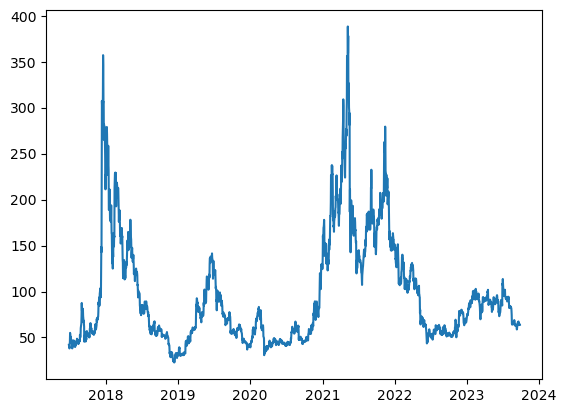

In [5]:
#plot historical ltc price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30 

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#scale data
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape

((2239, 30), (2239,), (2239,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1791, 30), (1791,), (224, 30), (224,), (224, 30), (224,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-26 15:56:05.749249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
56/56 [==============================] - 5s 39ms/step - loss: 5.2987 - mean_absolute_error: 1.7701 - val_loss: 0.0404 - val_mean_absolute_error: 0.1796
Epoch 2/100
56/56 [==============================] - 1s 23ms/step - loss: 0.3515 - mean_absolute_error: 0.5102 - val_loss: 0.1108 - val_mean_absolute_error: 0.2963
Epoch 3/100
56/56 [==============================] - 1s 23ms/step - loss: 0.2351 - mean_absolute_error: 0.4019 - val_loss: 0.0333 - val_mean_absolute_error: 0.1592
Epoch 4/100
56/56 [==============================] - 1s 23ms/step - loss: 0.0497 - mean_absolute_error: 0.1682 - val_loss: 0.0073 - val_mean_absolute_error: 0.0714
Epoch 5/100
56/56 [==============================] - 1s 23ms/step - loss: 0.0289 - mean_absolute_error: 0.1252 - val_loss: 0.0063 - val_mean_absolute_error: 0.0639
Epoch 6/100
56/56 [==============================] - 1s 22ms/step - loss: 0.0204 - mean_absolute_error: 0.1057 - val_loss: 0.0044 - val_mean_absolute_error: 0.0536
Epoch 7/100
56/5

Epoch 51/100
56/56 [==============================] - 2s 33ms/step - loss: 0.0046 - mean_absolute_error: 0.0498 - val_loss: 0.0025 - val_mean_absolute_error: 0.0390
Epoch 52/100
56/56 [==============================] - 2s 34ms/step - loss: 0.0058 - mean_absolute_error: 0.0572 - val_loss: 0.0032 - val_mean_absolute_error: 0.0443
Epoch 53/100
56/56 [==============================] - 2s 34ms/step - loss: 0.0044 - mean_absolute_error: 0.0480 - val_loss: 0.0019 - val_mean_absolute_error: 0.0315
Epoch 54/100
56/56 [==============================] - 2s 36ms/step - loss: 0.0042 - mean_absolute_error: 0.0462 - val_loss: 0.0031 - val_mean_absolute_error: 0.0445
Epoch 55/100
56/56 [==============================] - 2s 34ms/step - loss: 0.0048 - mean_absolute_error: 0.0511 - val_loss: 0.0025 - val_mean_absolute_error: 0.0387
Epoch 56/100
56/56 [==============================] - 2s 34ms/step - loss: 0.0041 - mean_absolute_error: 0.0455 - val_loss: 0.0019 - val_mean_absolute_error: 0.0316
Epoch 57/1

56/56 [==============================] - 1s 8ms/step


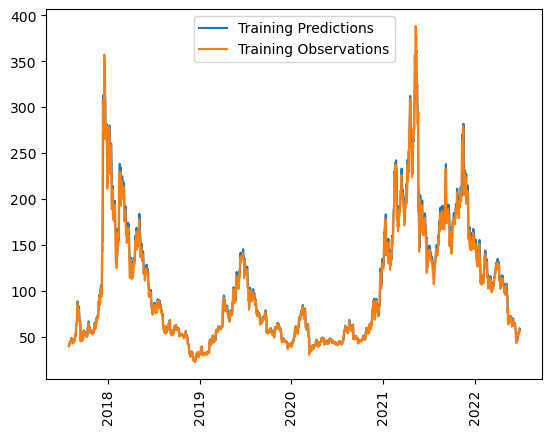

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0018986172508448362
Val MAE: 0.032273855060338974


7/7 [==============================] - 0s 9ms/step


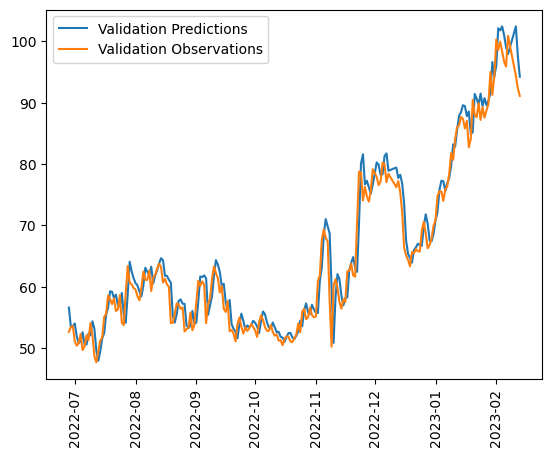

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0019570065196603537
Test MAE: 0.03190039470791817


7/7 [==============================] - 0s 8ms/step


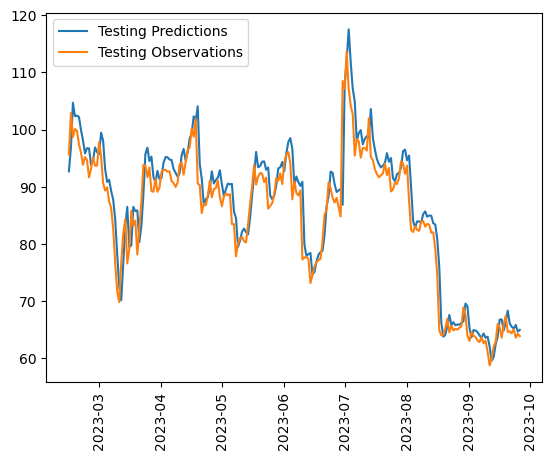

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9092168759281594


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((873,),
 (873, 30),
 (873,),
 (135,),
 (135, 30),
 (135,),
 (112,),
 (112, 30),
 (112,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
56/56 [==============================] - 6s 35ms/step - loss: 3.8545 - mean_absolute_error: 1.4460 - val_loss: 0.0903 - val_mean_absolute_error: 0.2674
Epoch 2/300
56/56 [==============================] - 1s 18ms/step - loss: 0.1919 - mean_absolute_error: 0.3567 - val_loss: 0.0102 - val_mean_absolute_error: 0.0804
Epoch 3/300
56/56 [==============================] - 1s 18ms/step - loss: 0.0417 - mean_absolute_error: 0.1535 - val_loss: 0.0065 - val_mean_absolute_error: 0.0630
Epoch 4/300
56/56 [==============================] - 1s 18ms/step - loss: 0.0229 - mean_absolute_error: 0.1128 - val_loss: 0.0082 - val_mean_absolute_error: 0.0738
Epoch 5/300
56/56 [==============================] - 1s 17ms/step - loss: 0.0143 - mean_absolute_error: 0.0863 - val_loss: 0.0052 - val_mean_absolute_error: 0.0572
Epoch 6/300
56/56 [==============================] - 1s 18ms/step - loss: 0.0126 - mean_absolute_error: 0.0816 - val_loss: 0.0079 - val_mean_absolute_error: 0.0750
Epoch 7/300
56/5

Epoch 51/300
56/56 [==============================] - 2s 34ms/step - loss: 0.0044 - mean_absolute_error: 0.0476 - val_loss: 0.0038 - val_mean_absolute_error: 0.0508
Epoch 52/300
56/56 [==============================] - 2s 35ms/step - loss: 0.0042 - mean_absolute_error: 0.0463 - val_loss: 0.0019 - val_mean_absolute_error: 0.0326
Epoch 53/300
56/56 [==============================] - 2s 36ms/step - loss: 0.0047 - mean_absolute_error: 0.0499 - val_loss: 0.0021 - val_mean_absolute_error: 0.0340
Epoch 54/300
56/56 [==============================] - 2s 42ms/step - loss: 0.0046 - mean_absolute_error: 0.0487 - val_loss: 0.0019 - val_mean_absolute_error: 0.0306
Epoch 55/300
56/56 [==============================] - 2s 34ms/step - loss: 0.0041 - mean_absolute_error: 0.0450 - val_loss: 0.0019 - val_mean_absolute_error: 0.0313
Epoch 56/300
56/56 [==============================] - 2s 42ms/step - loss: 0.0051 - mean_absolute_error: 0.0533 - val_loss: 0.0019 - val_mean_absolute_error: 0.0313
Epoch 57/3

Epoch 101/300
56/56 [==============================] - 2s 30ms/step - loss: 0.0042 - mean_absolute_error: 0.0477 - val_loss: 0.0034 - val_mean_absolute_error: 0.0485
Epoch 102/300
56/56 [==============================] - 2s 30ms/step - loss: 0.0042 - mean_absolute_error: 0.0466 - val_loss: 0.0018 - val_mean_absolute_error: 0.0305
Epoch 103/300
56/56 [==============================] - 2s 28ms/step - loss: 0.0042 - mean_absolute_error: 0.0469 - val_loss: 0.0027 - val_mean_absolute_error: 0.0410
Epoch 104/300
56/56 [==============================] - 2s 33ms/step - loss: 0.0039 - mean_absolute_error: 0.0443 - val_loss: 0.0025 - val_mean_absolute_error: 0.0386
Epoch 105/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0038 - mean_absolute_error: 0.0438 - val_loss: 0.0017 - val_mean_absolute_error: 0.0298
Epoch 106/300
56/56 [==============================] - 2s 29ms/step - loss: 0.0040 - mean_absolute_error: 0.0456 - val_loss: 0.0018 - val_mean_absolute_error: 0.0304
Epoc

56/56 [==============================] - 1s 24ms/step - loss: 0.0043 - mean_absolute_error: 0.0482 - val_loss: 0.0026 - val_mean_absolute_error: 0.0403
Epoch 151/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0041 - mean_absolute_error: 0.0471 - val_loss: 0.0035 - val_mean_absolute_error: 0.0492
Epoch 152/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0041 - mean_absolute_error: 0.0467 - val_loss: 0.0026 - val_mean_absolute_error: 0.0403
Epoch 153/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0043 - mean_absolute_error: 0.0482 - val_loss: 0.0017 - val_mean_absolute_error: 0.0292
Epoch 154/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0045 - mean_absolute_error: 0.0490 - val_loss: 0.0017 - val_mean_absolute_error: 0.0294
Epoch 155/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0037 - mean_absolute_error: 0.0431 - val_loss: 0.0019 - val_mean_absolute_error: 0.0330
Epoch 156/300
56/5

56/56 [==============================] - 1s 25ms/step - loss: 0.0039 - mean_absolute_error: 0.0451 - val_loss: 0.0019 - val_mean_absolute_error: 0.0317
Epoch 200/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0042 - mean_absolute_error: 0.0469 - val_loss: 0.0033 - val_mean_absolute_error: 0.0476
Epoch 201/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0040 - mean_absolute_error: 0.0447 - val_loss: 0.0033 - val_mean_absolute_error: 0.0468
Epoch 202/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0041 - mean_absolute_error: 0.0453 - val_loss: 0.0033 - val_mean_absolute_error: 0.0471
Epoch 203/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0041 - mean_absolute_error: 0.0454 - val_loss: 0.0020 - val_mean_absolute_error: 0.0341
Epoch 204/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0042 - mean_absolute_error: 0.0472 - val_loss: 0.0026 - val_mean_absolute_error: 0.0398
Epoch 205/300
56/5

56/56 [==============================] - 1s 24ms/step - loss: 0.0037 - mean_absolute_error: 0.0425 - val_loss: 0.0018 - val_mean_absolute_error: 0.0302
Epoch 249/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0038 - mean_absolute_error: 0.0436 - val_loss: 0.0018 - val_mean_absolute_error: 0.0304
Epoch 250/300
56/56 [==============================] - 1s 24ms/step - loss: 0.0039 - mean_absolute_error: 0.0444 - val_loss: 0.0024 - val_mean_absolute_error: 0.0389
Epoch 251/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0038 - mean_absolute_error: 0.0432 - val_loss: 0.0017 - val_mean_absolute_error: 0.0296
Epoch 252/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0037 - mean_absolute_error: 0.0438 - val_loss: 0.0028 - val_mean_absolute_error: 0.0419
Epoch 253/300
56/56 [==============================] - 1s 24ms/step - loss: 0.0037 - mean_absolute_error: 0.0428 - val_loss: 0.0017 - val_mean_absolute_error: 0.0293
Epoch 254/300
56/5

56/56 [==============================] - 1s 25ms/step - loss: 0.0038 - mean_absolute_error: 0.0437 - val_loss: 0.0023 - val_mean_absolute_error: 0.0361
Epoch 298/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0040 - mean_absolute_error: 0.0448 - val_loss: 0.0018 - val_mean_absolute_error: 0.0307
Epoch 299/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0047 - mean_absolute_error: 0.0508 - val_loss: 0.0054 - val_mean_absolute_error: 0.0647
Epoch 300/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0040 - mean_absolute_error: 0.0459 - val_loss: 0.0028 - val_mean_absolute_error: 0.0417


56/56 [==============================] - 1s 7ms/step


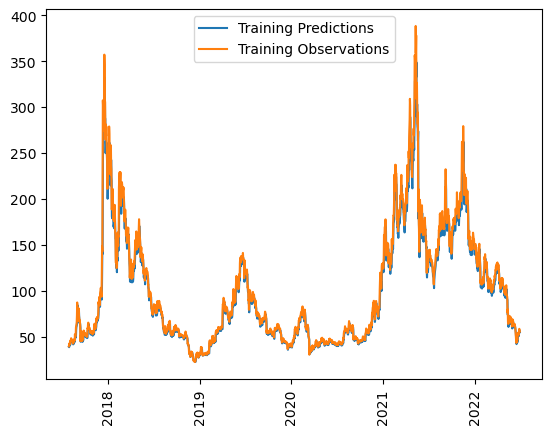

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions2))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0025760182179510593
Val MAE: 0.04252277687191963


5/5 [==============================] - 0s 7ms/step


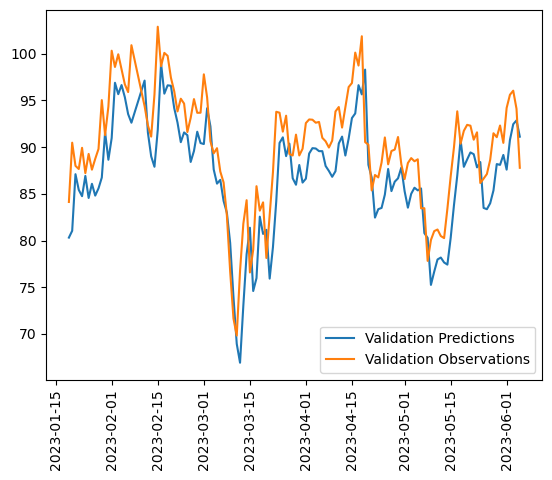

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0026646575424820185
Test MAE: 0.04083976149559021


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 6ms/step
R2 Score:  0.9116183608726521


4/4 [==============================] - 0s 7ms/step


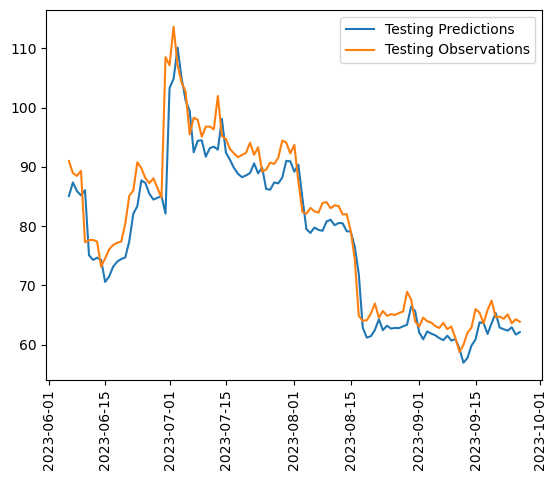

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 5s 57ms/step - loss: 21.6482 - mean_absolute_error: 4.6209 - val_loss: 18.9324 - val_mean_absolute_error: 4.3506
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 19.5185 - mean_absolute_error: 4.3854 - val_loss: 16.5960 - val_mean_absolute_error: 4.0733
Epoch 3/300
28/28 [==============================] - 1s 28ms/step - loss: 17.0619 - mean_absolute_error: 4.0965 - val_loss: 14.0308 - val_mean_absolute_error: 3.7452
Epoch 4/300
28/28 [==============================] - 1s 25ms/step - loss: 13.8657 - mean_absolute_error: 3.6842 - val_loss: 10.5417 - val_mean_absolute_error: 3.2461
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 10.1168 - mean_absolute_error: 3.1320 - val_loss: 6.9698 - val_mean_absolute_error: 2.6391
Epoch 6/300
28/28 [==============================] - 1s 26ms/step - loss: 6.5728 - mean_absolute_error: 2.5012 - val_loss: 3.9091 - val_mean_absolute_error: 1.9759
Epoch 7

Epoch 51/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0140 - mean_absolute_error: 0.0893 - val_loss: 0.0040 - val_mean_absolute_error: 0.0491
Epoch 52/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0141 - mean_absolute_error: 0.0900 - val_loss: 0.0043 - val_mean_absolute_error: 0.0491
Epoch 53/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0141 - mean_absolute_error: 0.0897 - val_loss: 0.0044 - val_mean_absolute_error: 0.0493
Epoch 54/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0142 - mean_absolute_error: 0.0896 - val_loss: 0.0039 - val_mean_absolute_error: 0.0480
Epoch 55/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0137 - mean_absolute_error: 0.0879 - val_loss: 0.0048 - val_mean_absolute_error: 0.0560
Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0134 - mean_absolute_error: 0.0869 - val_loss: 0.0038 - val_mean_absolute_error: 0.0482
Epoch 57/3

Epoch 101/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0087 - mean_absolute_error: 0.0681 - val_loss: 0.0029 - val_mean_absolute_error: 0.0411
Epoch 102/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0085 - mean_absolute_error: 0.0675 - val_loss: 0.0027 - val_mean_absolute_error: 0.0391
Epoch 103/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0083 - mean_absolute_error: 0.0663 - val_loss: 0.0027 - val_mean_absolute_error: 0.0388
Epoch 104/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0086 - mean_absolute_error: 0.0677 - val_loss: 0.0028 - val_mean_absolute_error: 0.0407
Epoch 105/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0083 - mean_absolute_error: 0.0664 - val_loss: 0.0038 - val_mean_absolute_error: 0.0496
Epoch 106/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0084 - mean_absolute_error: 0.0675 - val_loss: 0.0027 - val_mean_absolute_error: 0.0396
Epoc

28/28 [==============================] - 1s 26ms/step - loss: 0.0061 - mean_absolute_error: 0.0566 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355
Epoch 151/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0060 - mean_absolute_error: 0.0563 - val_loss: 0.0024 - val_mean_absolute_error: 0.0378
Epoch 152/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0059 - mean_absolute_error: 0.0559 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353
Epoch 153/300
28/28 [==============================] - 1s 31ms/step - loss: 0.0063 - mean_absolute_error: 0.0581 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354
Epoch 154/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0058 - mean_absolute_error: 0.0558 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353
Epoch 155/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0063 - mean_absolute_error: 0.0586 - val_loss: 0.0023 - val_mean_absolute_error: 0.0374
Epoch 156/300
28/2

28/28 [==============================] - 1s 29ms/step - loss: 0.0049 - mean_absolute_error: 0.0505 - val_loss: 0.0020 - val_mean_absolute_error: 0.0348
Epoch 200/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0049 - mean_absolute_error: 0.0512 - val_loss: 0.0019 - val_mean_absolute_error: 0.0332
Epoch 201/300
28/28 [==============================] - 1s 29ms/step - loss: 0.0048 - mean_absolute_error: 0.0499 - val_loss: 0.0021 - val_mean_absolute_error: 0.0341
Epoch 202/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0049 - mean_absolute_error: 0.0506 - val_loss: 0.0019 - val_mean_absolute_error: 0.0330
Epoch 203/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0051 - mean_absolute_error: 0.0522 - val_loss: 0.0019 - val_mean_absolute_error: 0.0325
Epoch 204/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0049 - mean_absolute_error: 0.0498 - val_loss: 0.0025 - val_mean_absolute_error: 0.0403
Epoch 205/300
28/2

28/28 [==============================] - 0s 16ms/step - loss: 0.0042 - mean_absolute_error: 0.0466 - val_loss: 0.0018 - val_mean_absolute_error: 0.0308
Epoch 249/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0043 - mean_absolute_error: 0.0470 - val_loss: 0.0018 - val_mean_absolute_error: 0.0306
Epoch 250/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0042 - mean_absolute_error: 0.0460 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323
Epoch 251/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_absolute_error: 0.0484 - val_loss: 0.0021 - val_mean_absolute_error: 0.0359
Epoch 252/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0042 - mean_absolute_error: 0.0465 - val_loss: 0.0017 - val_mean_absolute_error: 0.0306
Epoch 253/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0042 - mean_absolute_error: 0.0468 - val_loss: 0.0026 - val_mean_absolute_error: 0.0412
Epoch 254/300
28/2

28/28 [==============================] - 0s 16ms/step - loss: 0.0039 - mean_absolute_error: 0.0444 - val_loss: 0.0017 - val_mean_absolute_error: 0.0302
Epoch 298/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_absolute_error: 0.0456 - val_loss: 0.0024 - val_mean_absolute_error: 0.0395
Epoch 299/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0041 - mean_absolute_error: 0.0469 - val_loss: 0.0016 - val_mean_absolute_error: 0.0294
Epoch 300/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0432 - val_loss: 0.0017 - val_mean_absolute_error: 0.0303


28/28 [==============================] - 1s 5ms/step


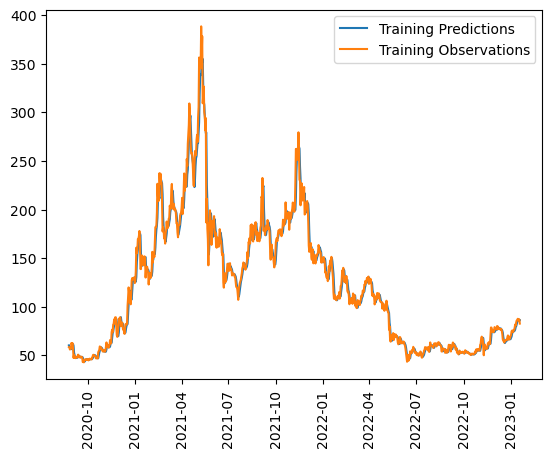

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.001668448094278574
Val MAE: 0.0303274504840374


5/5 [==============================] - 0s 5ms/step


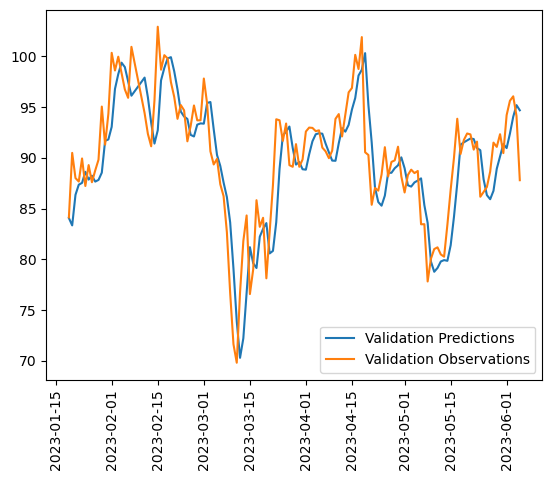

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.002075838390737772
Test MAE: 0.02950899489223957


4/4 [==============================] - 0s 5ms/step


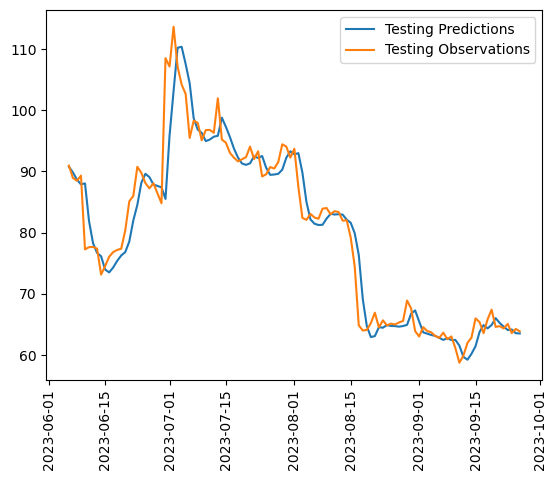

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9311483327078733


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the highest scoring model for future predictions

In [32]:
# Use the first model to predict future values since it has the highest r2 score

# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

# add future dates for predictions
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 22ms/step
[4.1737065, 4.178371, 4.179583, 4.179257, 4.1787252, 4.178423, 4.178324]
2023-09-27
2023-09-28
2023-09-29
2023-09-30
2023-10-01
2023-10-02
2023-10-03


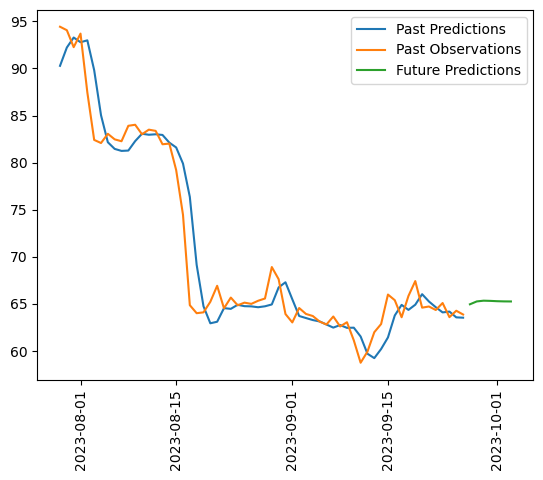

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/ltc_30_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/ltc_30_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_30_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-29,84.80,89.617332,85.051331,87.394287
2023-06-30,108.50,86.839180,82.107010,85.503021
2023-07-01,107.13,107.753410,103.284454,95.826843
2023-07-02,113.63,112.225471,104.831146,103.105537
2023-07-03,107.10,117.525398,110.107697,110.187790
...,...,...,...,...
2023-09-22,64.35,65.502594,62.589153,64.644676
2023-09-23,65.09,65.161263,62.352390,64.095352
2023-09-24,63.59,65.823097,62.923100,64.180122


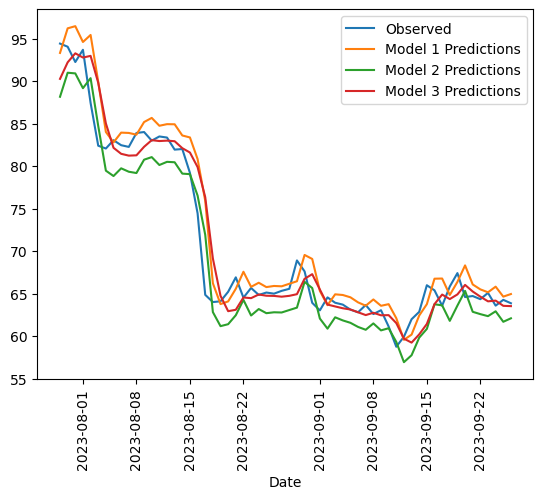

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/ltc_predict_30.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime_30.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9092168759281594
Model 2 R2 Score:  0.9116183608726521
Model 3 R2 Score:  0.9311483327078733
